# FCNN training

In [1]:
# This is only valid when the package is not installed
import sys
sys.path.append('../../') # two folders up
import DeepINN as dp
import torch
import numpy as np

Using default backend: PyTorch
Using Pytorch:  2.0.1+cu117


## Geometry

In [2]:
# A simple 1D geometry
X = dp.spaces.R2('x')
Rect = dp.domains.Parallelogram(X, [0,0], [1,0], [0,1]) # unit square

In [3]:
left_bc = dp.constraint.DirichletBC(geom = Rect,
                                      function = lambda X: X[:,0]*torch.tensor([0.0]), # this is a bug. We need to somehow involved X in the lambda otherwise it will give shape error.
                                      sampling_strategy = "grid",
                                      no_points = 10, 
                                      filter_fn = lambda x: x[:, 0] == 0.0)
right_bc = dp.constraint.DirichletBC(geom = Rect,
                                      function = lambda X: X[:,0]*torch.tensor([1.0]), # this is a bug. We need to somehow involved X in the lambda otherwise it will give shape error.
                                      sampling_strategy = "grid",
                                      no_points = 10, # you can use more points. there are conditions to deal with stupid conditions. 
                                      filter_fn = lambda x: x[:, 0] == 1.0)

interior_points = dp.constraint.PDE(geom = Rect,
                                    sampling_strategy= "LatinHypercube",
                                    no_points = 100)

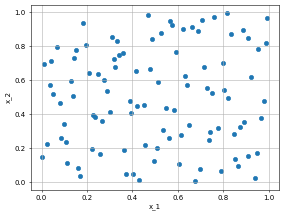

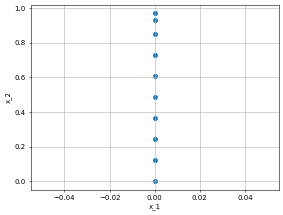

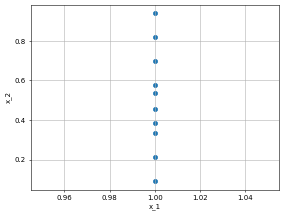

In [4]:
dp.utils.scatter(X, interior_points.sampler_object(), dpi = 50) # collocation points
dp.utils.scatter(X, left_bc.sampler_object(), dpi = 50)
dp.utils.scatter(X, right_bc.sampler_object(), dpi = 50)

## PDE

In [5]:
def laplace(X,y):
    """
    2D Laplace equation.
    u__x + u__y = 0
     i is always zero because output to the NN is always 1D
    """
    dy_x = dp.constraint.Jacobian(X, y)(i=0, j=0)
    dy_xx = dp.constraint.Jacobian(X, dy_x)(i = 0, j = 0)

    dy_y = dp.constraint.Jacobian(X, y)(i=0, j=1)
    dy_yy = dp.constraint.Jacobian(X, dy_y)(i = 0, j = 1)

    return dy_xx + dy_yy

In [6]:
domain = dp.domain.Generic(laplace,
                            interior_points,
                            [left_bc, right_bc])

## Network

In [7]:
activation = "tanh"
initialiser = "Xavier normal"
layer_size = [2] + [2] * 1 + [1]

In [8]:
net = dp.nn.FullyConnected(layer_size, activation, initialiser)
model = dp.Model(domain, net)

In [9]:
optimiser = "adam"
lr=0.001
metrics="MSE"

model.compile(optimiser, lr, metrics, device = "cuda")

Domain compiled
Network compiled


In [10]:
model.optimiser_function, model.lr, model.metric

(torch.optim.adam.Adam, 0.001, MSELoss())

In [11]:
model.train(iterations = 5000)

Iteration: 1 	 BC Loss: 0.4289	 PDE Loss: 0.1653 	 Loss: 0.5942
Iteration: 501 	 BC Loss: 0.0210	 PDE Loss: 0.0000 	 Loss: 0.0210
Iteration: 1001 	 BC Loss: 0.0000	 PDE Loss: 0.0000 	 Loss: 0.0000
Iteration: 1501 	 BC Loss: 0.0000	 PDE Loss: 0.0000 	 Loss: 0.0000
Iteration: 2001 	 BC Loss: 0.0000	 PDE Loss: 0.0000 	 Loss: 0.0000
Iteration: 2501 	 BC Loss: 0.0000	 PDE Loss: 0.0000 	 Loss: 0.0000
Iteration: 3001 	 BC Loss: 0.0000	 PDE Loss: 0.0000 	 Loss: 0.0000
Iteration: 3501 	 BC Loss: 0.0000	 PDE Loss: 0.0000 	 Loss: 0.0000
Iteration: 4001 	 BC Loss: 0.0000	 PDE Loss: 0.0000 	 Loss: 0.0000
Iteration: 4501 	 BC Loss: 0.0000	 PDE Loss: 0.0000 	 Loss: 0.0000
Iteration: 5001 	 BC Loss: 0.0000	 PDE Loss: 0.0000 	 Loss: 0.0000
Training finished
Time taken: 'trainer' in 29.4198 secs


In [12]:
# model.iter = 1
# model.train(iterations = 2000)

In [13]:
model.network

FullyConnected(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=1, bias=True)
  )
)

In [14]:
coordinates_list = dp.utils.tensor2numpy([model.collocation_point_sample, model.boundary_point_sample])
solution_list = dp.utils.tensor2numpy([model.collocation_forward, model.BC_forward])

In [15]:
history = model.training_history

In [16]:
import matplotlib.pyplot as plt

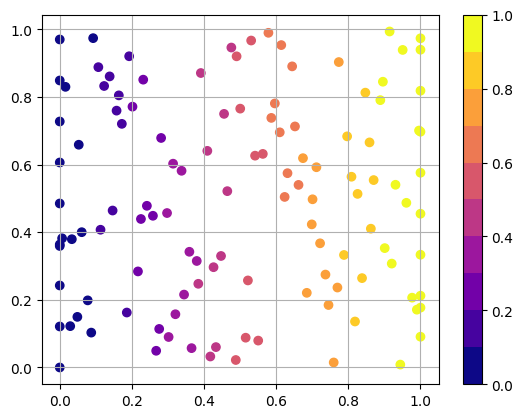

In [20]:
plt.figure(1)
plt.scatter(coordinates_list[0][:,0], coordinates_list[0][:,1], c=solution_list[0][:,0], label = "collocation points",  cmap=plt.get_cmap('plasma', 10))
plt.scatter(coordinates_list[1][:,0], coordinates_list[1][:,1], c=solution_list[1], label = "boundary points", cmap=plt.get_cmap('plasma', 10))
plt.colorbar()
plt.grid('minor')

Text(0, 0.5, 'Loss')

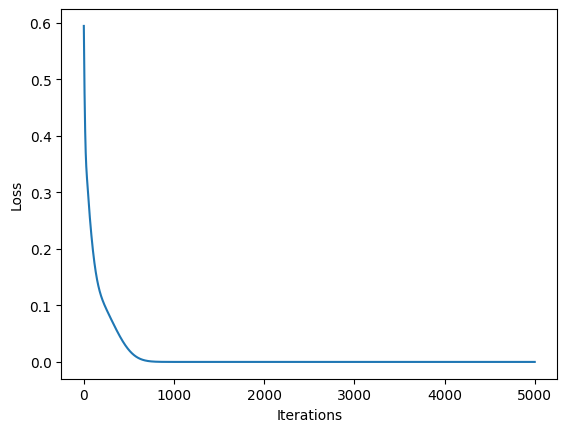

In [19]:
plt.figure(2)
plt.plot(history)
plt.xlabel("Iterations")
plt.ylabel("Loss")